# Using multimetric experiments in SigOpt to identify multiple good solutions

If you have not yet done so, please make sure you are comfortable with the content in the [intro](multimetric_intro.ipynb) notebook.

Below we create the standard SigOpt [connection](https://sigopt.com/docs/overview/python) tool.  If the `SIGOPT_API_TOKEN` is present in the environment variables, it is imported; otherwise, you need to copy and paste your key from your [profile page](https://sigopt.com/user/profile).

In [1]:
import os
import numpy
from time import sleep
from matplotlib import pyplot as plt
%matplotlib inline

# Matplotlib stuff for generating plots
efficient_opts = {'linewidth': 0, 'marker': '+', 'color': 'r', 'markersize': 10, 'markeredgewidth': 2}

from sigopt.interface import Connection

if 'SIGOPT_API_TOKEN' in os.environ:
    SIGOPT_API_TOKEN = os.environ['SIGOPT_API_TOKEN']
else:
    SIGOPT_API_TOKEN = None
    
assert SIGOPT_API_TOKEN is not None
conn = Connection(client_token=SIGOPT_API_TOKEN)

One natural situation for a multimetric experiment is in finding a second answer to an optimization problem.  Given a function $f$ and domain $\Omega$ on which the maximum of $f$ occurs at $x^*$, the search for other points which have high values but are at least some distance away can be phrased as

\begin{align}
    \text{value}:&\quad \max_{x\in\Omega} f(x) \\
    \text{distance}:&\quad \max_{x\in\Omega} \|x - x^*\| \\
\end{align}

Here the norm is presumed to be the 2-norm, but could actually be any measurement of distance; that ambiguity is especially valuable in the situation where categorical parameters are present or a custom definition of distance is preferred.

### Finding $x^*$, the solution to the standard optimization of $f$

We start by defining a multimodal function $f$ which has multiple local optima below.  The associated meta is for a standard, single metric experiment.

In [2]:
def multimodal_function(x1, x2):    
    return (
        .5 * numpy.exp(-10 * ((x1 + .8) ** 2 + .3 * (x2 + .6) ** 2)) +
        .5 * numpy.exp(-9 * (.4 * (x1 + .7) ** 2 + .4 * (x2 - .4) ** 2)) +
        .5 * numpy.exp(-11 * (.2 * (x1 - .6) ** 2 + .5 * (x2 + .5) ** 2)) +
        .5 * numpy.exp(-11 * (.6 * (x1) ** 2 + .5 * (x2 + .8) ** 2)) +
        .5 * numpy.exp(-12 * (.4 * (x1 - .1) ** 2 + .7 * (x2 - .8) ** 2)) +
        .5 * numpy.exp(-13 * (.8 * (x1) ** 2 + .7 * (x2) ** 2)) +
        .5 * numpy.exp(-8 * (.3 * (x1 - .8) ** 2 + .6 * (x2 - .3) ** 2))
    )

multimodal_first_solution_meta = {
    'name': 'SigOpt Multimetric Demo - Single Metric Optimization (python)',
    'metrics': [{'name': 'value'}],
    'parameters': [
        {'name': 'x1', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'},
        {'name': 'x2', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'},
    ],
    'type': 'offline',
    'observation_budget': 40,
}

We can run the initial optimization to find this $x^*$ value which is the maximum of the function.  The `sleep(3)` command helps simulate an actual experiment, where the cost of creating an observation is (significant) greater than the function we are studying here.

In [3]:
experiment = conn.experiments().create(**multimodal_first_solution_meta)

In [4]:
while experiment.progress.observation_count < experiment.observation_budget:
    suggestion = conn.experiments(experiment.id).suggestions().create()
    sleep(3)
    value = multimodal_function(**suggestion.assignments)
    conn.experiments(experiment.id).observations().create(suggestion=suggestion.id, value=value)
    experiment = conn.experiments(experiment.id).fetch()

The solution to this problem $x^*$ must be extracted for identifying a second solution.

In [5]:
initial_optimization_best_assignments = conn.experiments(experiment.id).best_assignments().fetch()
x_star = initial_optimization_best_assignments.data[0].assignments

This contour plot shows that there is an amount of complexity in this function, and that choosing a diverse portfolio of solutions may be difficult.  The initial solution $x^*$, as determined from the optimization above, is also plotted.

/Users/mccourt/Envs/moe_venv/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/mccourt/Envs/moe_venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


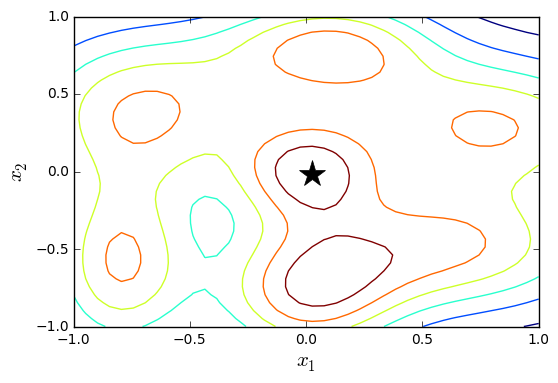

In [6]:
xplt = numpy.linspace(-1, 1, 40)
X1, X2 = numpy.meshgrid(xplt, xplt)
Y = multimodal_function(x1=X1, x2=X2)
plt.contour(X1, X2, Y)
plt.plot(x_star['x1'], x_star['x2'], '*k', markersize=20)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15);

### Using the initial solution $x^*$ to search for a second solution

Now that we have this initial solution, we can define our multimetric experiment.  Note that the distance we are using is the standard 2-norm.  The multimetric function returns a list of dictionaries, one each per metric to be optimized.

In [7]:
def distance_function(assignments, x_star):
    return numpy.sqrt((assignments['x1'] - x_star['x1']) ** 2 + (assignments['x2'] - x_star['x2']) ** 2)

def multimetric_value_distance_function(assignments, x_star):
    function_value = multimodal_function(**assignments)
    distance_from_x_star = distance_function(assignments, x_star)
    return [
        {'name': 'function value', 'value': function_value},
        {'name': 'distance from x_star', 'value': distance_from_x_star},
    ]

multimetric_second_solution_meta = {
    'name': 'SigOpt Multimetric Demo - Search for Second Solution (python)',
    'metrics': [{'name': 'function value'}, {'name': 'distance from x_star'}],
    'parameters': [
        {'name': 'x1', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'},
        {'name': 'x2', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'},
    ],
    'type': 'offline',
    'observation_budget': 100,
}

In [8]:
experiment = conn.experiments().create(**multimetric_second_solution_meta)

In [9]:
while experiment.progress.observation_count < experiment.observation_budget:
    suggestion = conn.experiments(experiment.id).suggestions().create()
    sleep(3)
    values = multimetric_value_distance_function(suggestion.assignments, x_star)
    conn.experiments(experiment.id).observations().create(suggestion=suggestion.id, values=values)
    experiment = conn.experiments(experiment.id).fetch()

Extracting the solution to this multimetric optimization problem yields an array of points, each of which is [Pareto efficient](https://www.sigopt.com/docs/overview/pareto_efficiency).  Plotting the metric values associated with these efficient points can help provide some guidance as to what possible solutions are available, and which might be preferred in an actual application.

Recall that metric evaluations are organized in **alphabetical order** when returned from SigOpt, which may differ from the order in which they were originally defined in the experiment.  The loop below recovers the values in the same value in which they were defined initially.

We also, again, produce some random data to explore the full feasible domain.

In [10]:
pareto_efficient_results = conn.experiments(experiment.id).best_assignments().fetch()
efficient_points = numpy.empty((pareto_efficient_results.count, 2))
efficient_values = numpy.empty((pareto_efficient_results.count, 2))
for k, data in enumerate(pareto_efficient_results.data):
    efficient_points[k, :] = [data.assignments['x1'], data.assignments['x2']]
    dv = {d.name: d.value for d in data.values}
    efficient_values[k, :] = [dv[m['name']] for m in multimetric_second_solution_meta['metrics']]

rand_pts = numpy.random.uniform(
    [p['bounds']['min'] for p in multimetric_second_solution_meta['parameters']],
    [p['bounds']['max'] for p in multimetric_second_solution_meta['parameters']],
    (1000, 2)
)
random_values = numpy.empty((len(rand_pts), 2))
for k, pt in enumerate(rand_pts):
    random_values[k, :] = [v['value'] for v in multimetric_value_distance_function({'x1': pt[0], 'x2': pt[1]}, x_star)]

The graph on the left again shows the SigOpt generated Pareto frontier with the red + signs.  As we can see for this multimetric experiment, multiple regions of solutions emerge which have high values but are at least some distance away.  This contour plot is only feasible for low dimensional problems -- for higher dimensional problems a different analysis of the efficient points will be necessary.

Note that, if you run this experiment again you may get a different distribution of points.

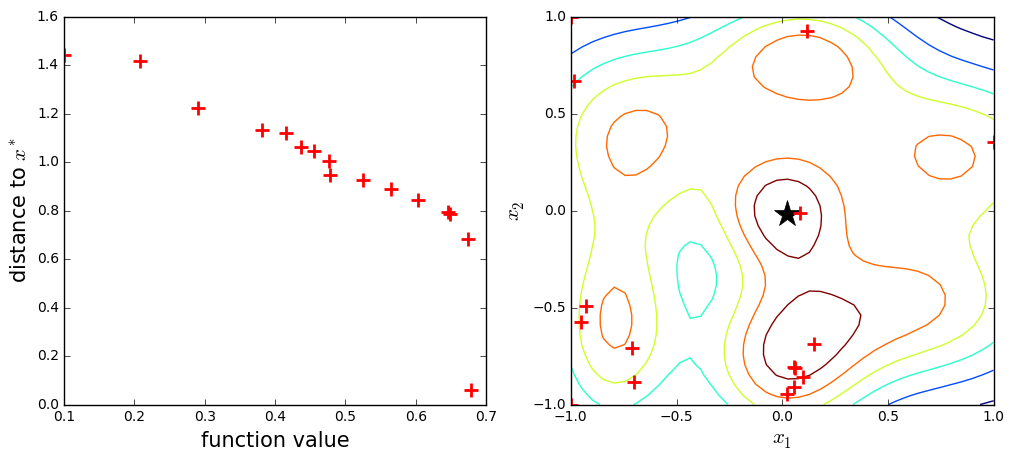

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(efficient_values[:, 0], efficient_values[:, 1], **efficient_opts)
ax1.set_xlabel('function value', fontsize=15)
ax1.set_ylabel('distance to $x^*$', fontsize=15)

xplt = numpy.linspace(-1, 1, 40)
X1, X2 = numpy.meshgrid(xplt, xplt)
Y = multimodal_function(x1=X1, x2=X2)
ax2.contour(X1, X2, Y)
ax2.plot(x_star['x1'], x_star['x2'], '*k', markersize=20)
ax2.plot(efficient_points[:, 0], efficient_points[:, 1], **efficient_opts)
ax2.set_xlabel('$x_1$', fontsize=15)
ax2.set_ylabel('$x_2$', fontsize=15);